# Revolutionizing Real Estate: A Machine Learning Approach to Predict House Prices

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as stats

sb.set()

In [2]:
df = pd.read_csv("house_pricing.csv")
df = df.drop(columns=['Id'])
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [3]:
x = [y for y in df.columns[df.isna().sum() > 0]]

na_categorical_variables = []
na_continuous_variables = []

categorical_variables = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
                         "HouseStyle", "OverallQual", "OverallCond", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", 
                         "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType",
                         "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition", "MoSold", "YrSold", "BsmtFullBath", "BsmtHalfBath", 
                         "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars"]

continuous_variables = []

for column in df.columns:
    if column not in categorical_variables:
        continuous_variables.append(column)

for column in x:
    if column in categorical_variables:
        na_categorical_variables.append(column)
    else:
        na_continuous_variables.append(column)

print(f"NA Categorical variables : {na_categorical_variables}")
print(f"NA Continuous variables : {na_continuous_variables}")

NA Categorical variables : ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
NA Continuous variables : ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


Most of the categorical categories that have NA as one of their options

In [4]:
continuous_variables

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice']

In [5]:
# Fix the na values

# assume every neighbourhood has similar LotFrontage
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# assume theyt have no garage and no Masonry veneer area
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [6]:
# treat the NAs as literal string and not as a missing value
na_as_category = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'MiscFeature'
]

# Replace NaN with "NA" where appropriate
df[na_as_category] = df[na_as_category].fillna("NA")

In [7]:
cont_df = df[continuous_variables]
cat_df = df[categorical_variables]

## Exploratory Analysis

### Categorical

In [8]:
high_cardinality = []
low_cardinality = []

for column in cat_df.columns:
    if len(cat_df[column].unique()) > 2:
        high_cardinality.append(column)
    else:
        low_cardinality.append(column)

print(len(high_cardinality))
print(len(low_cardinality))

54
3


Street
Pave    1454
Grvl       6
Name: count, dtype: int64
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64
CentralAir
Y    1365
N      95
Name: count, dtype: int64


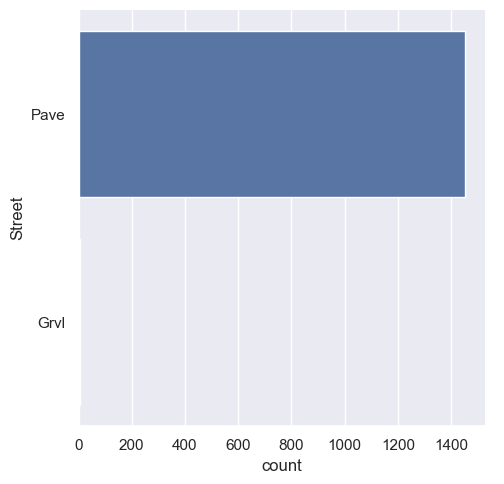

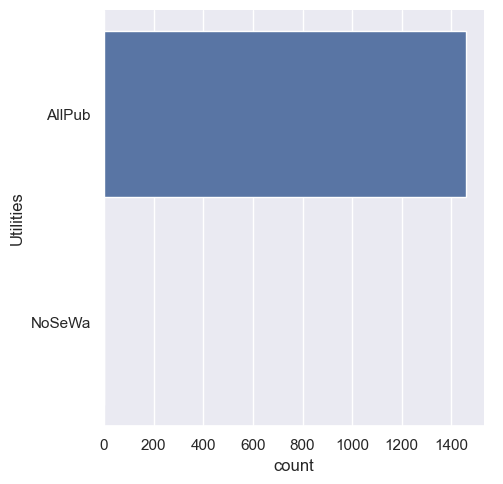

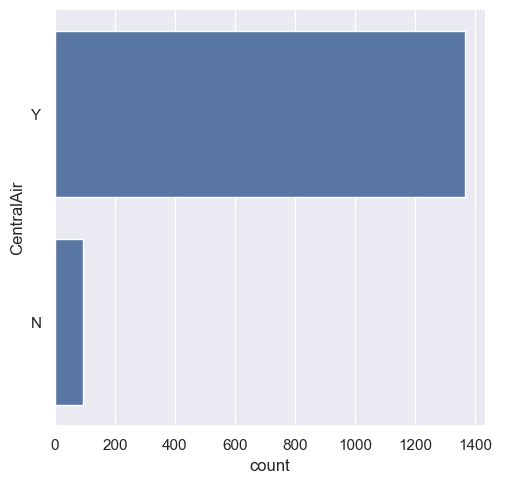

In [9]:
for column in low_cardinality:
    print(cat_df[column].value_counts())
    sb.catplot(y = column, data = cat_df, kind = "count")

Dataset is rather unbalanced for each of the low cardinality categorical variables.

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


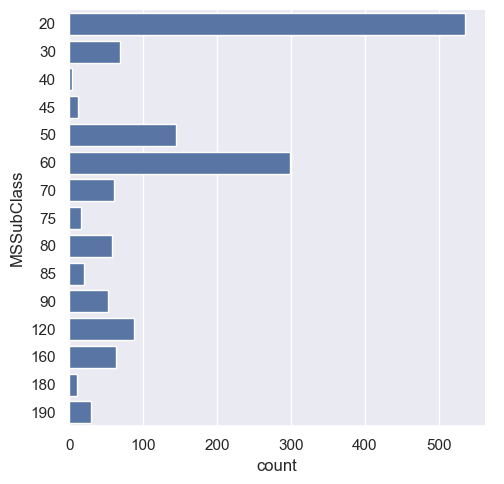

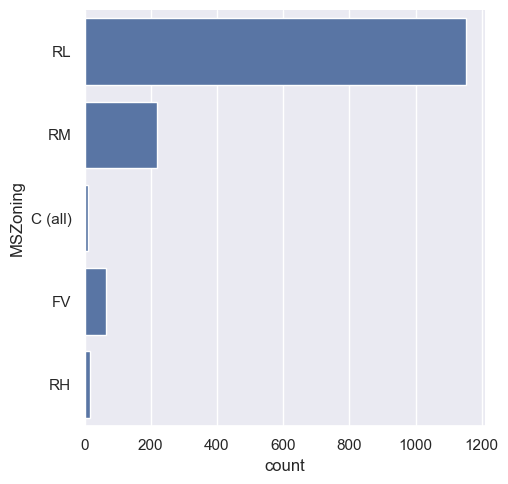

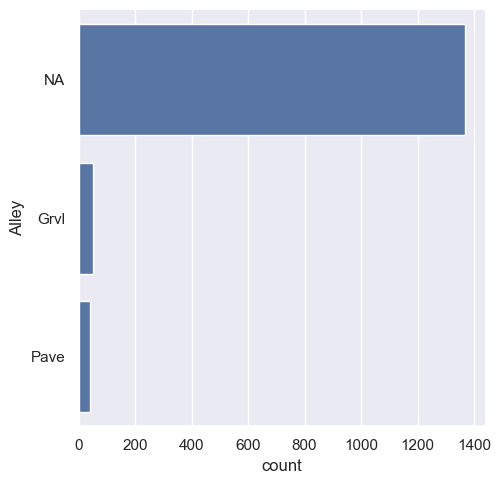

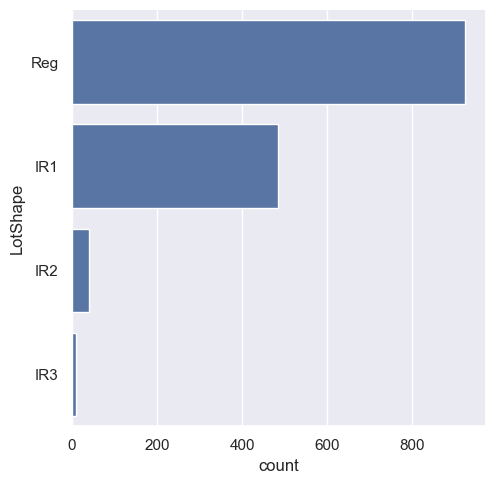

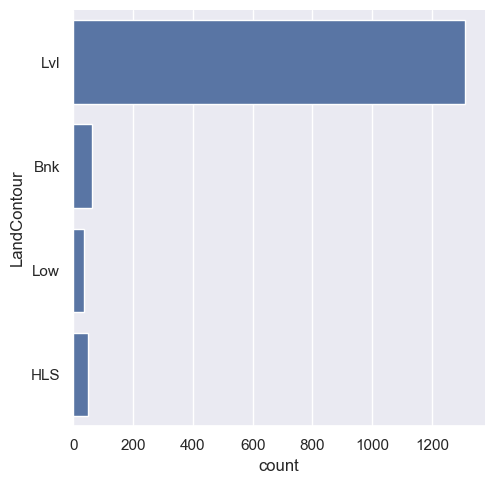

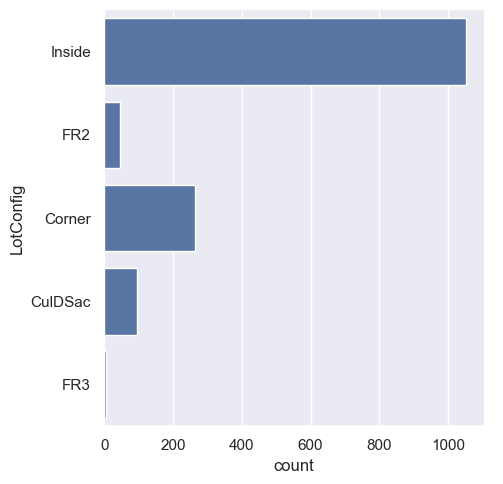

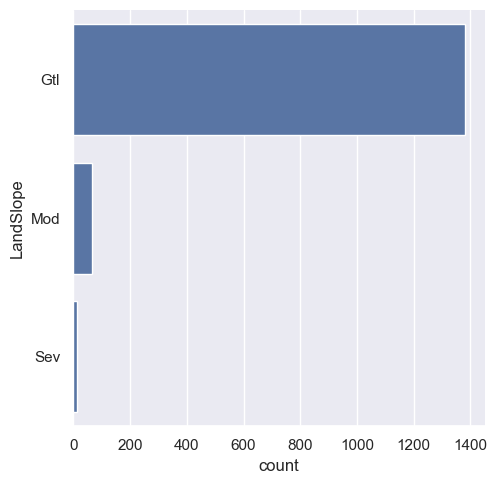

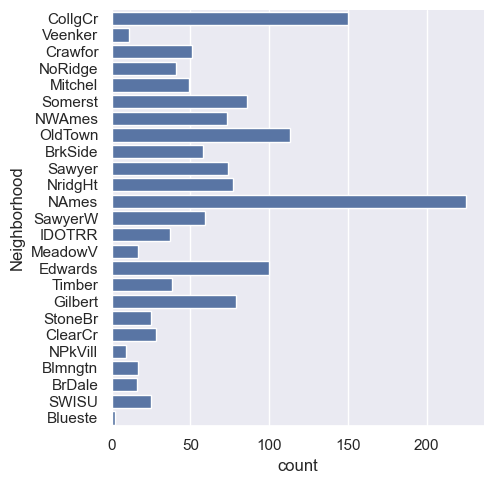

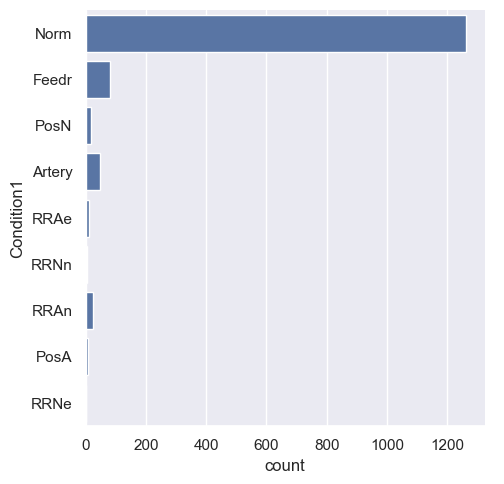

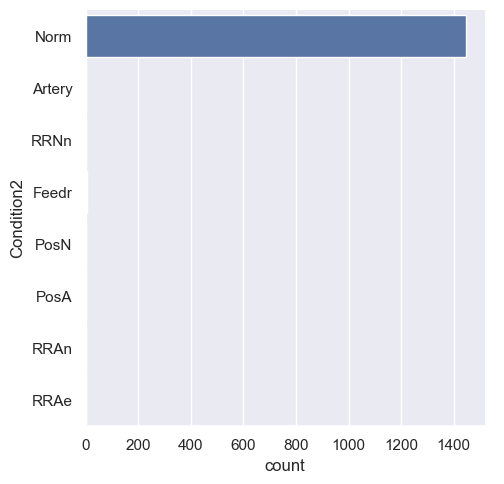

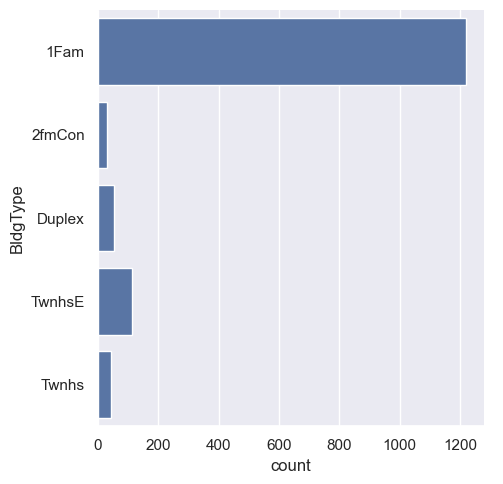

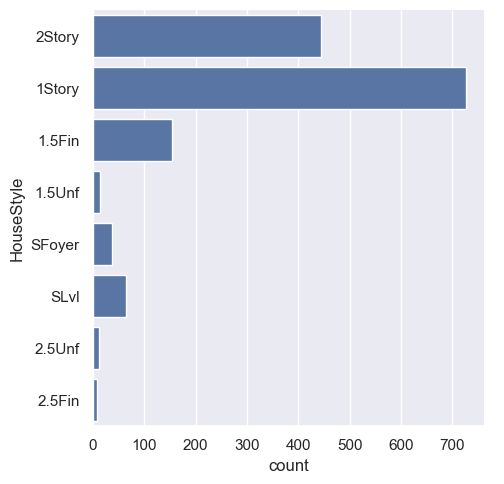

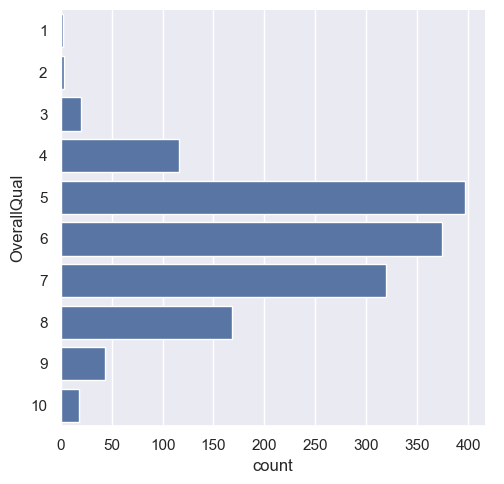

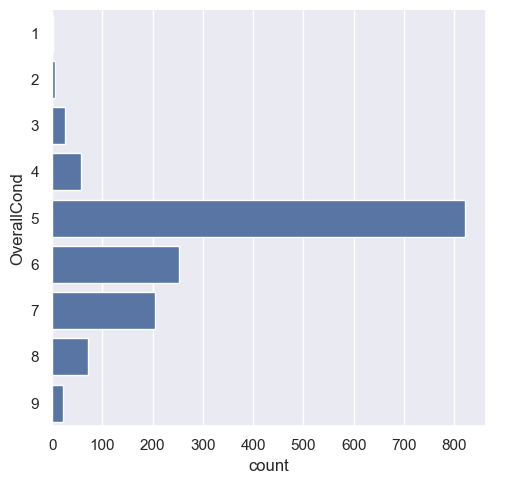

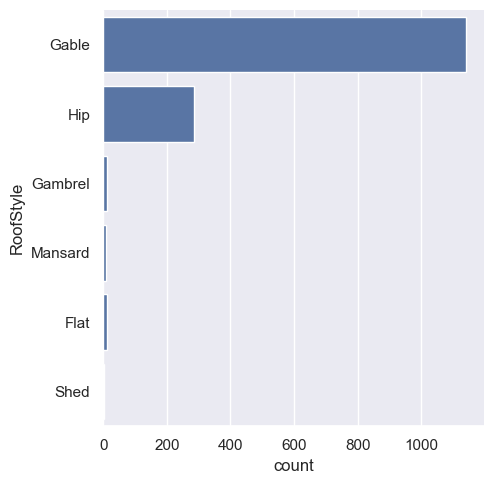

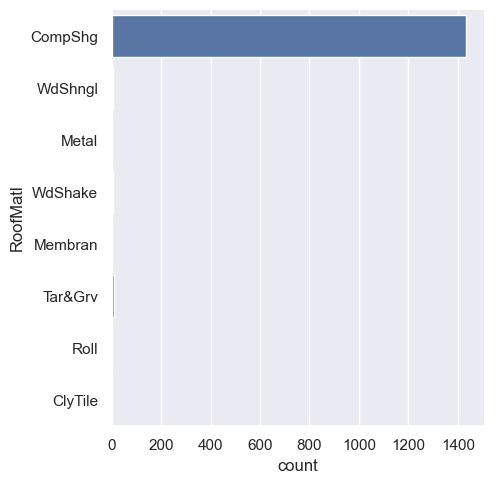

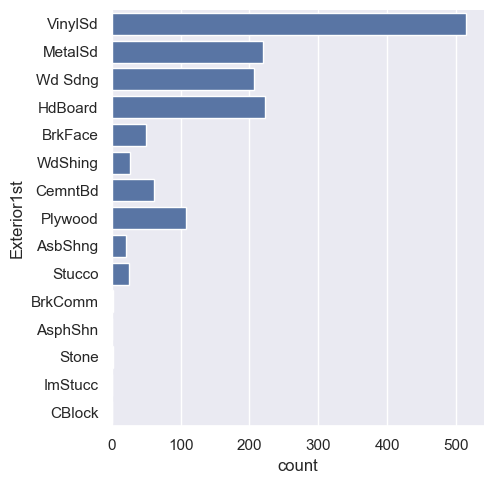

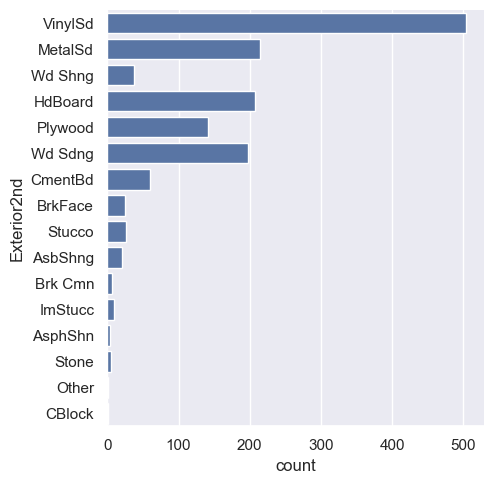

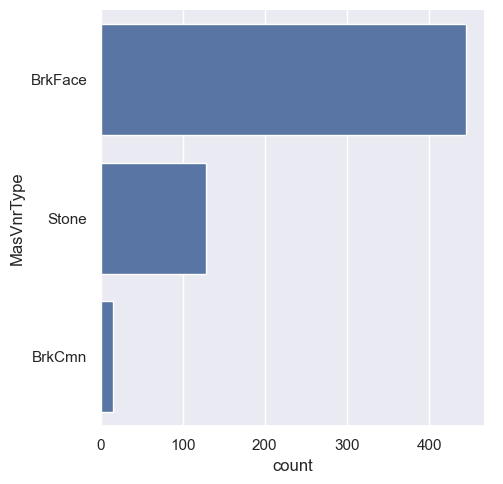

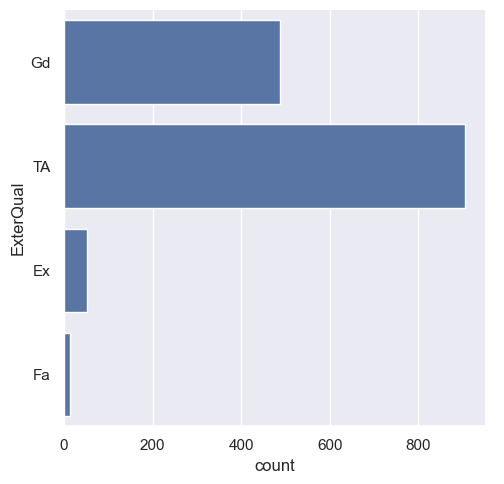

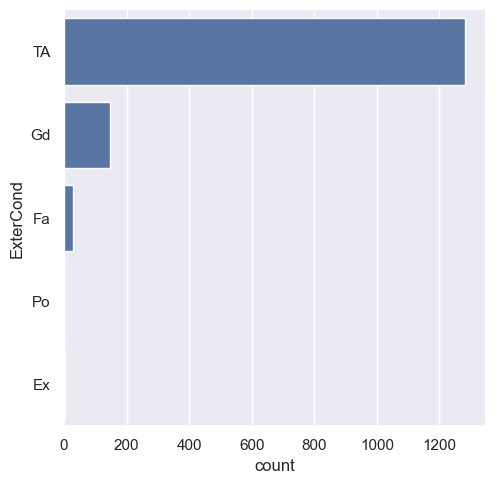

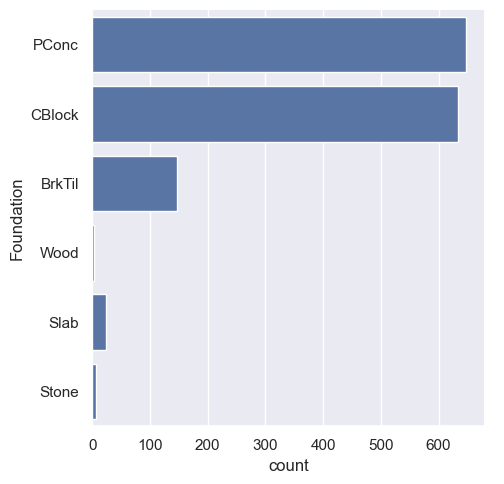

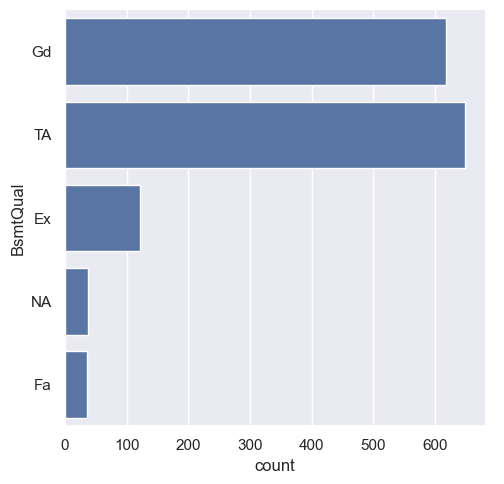

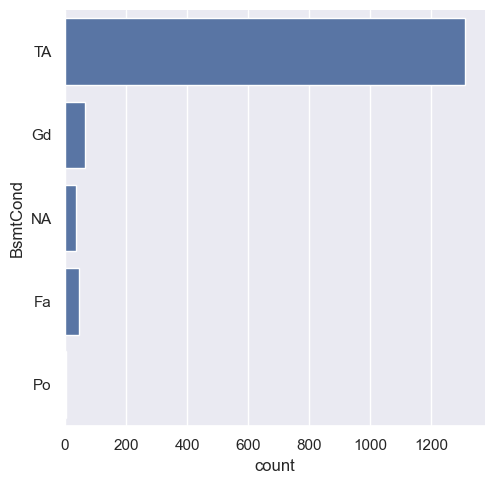

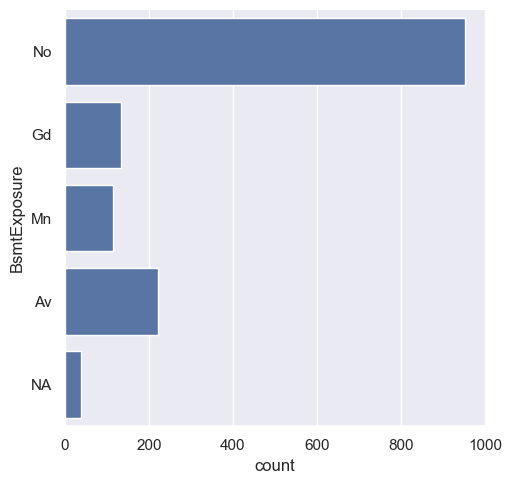

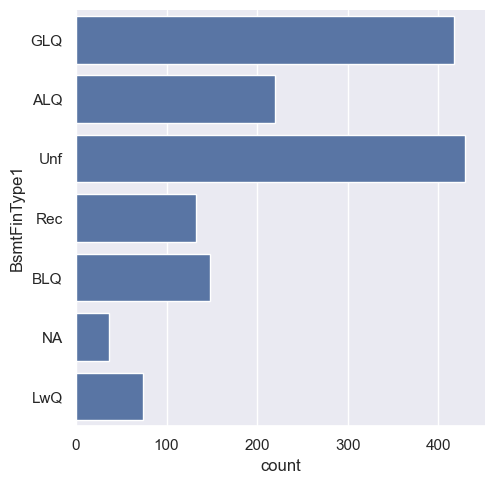

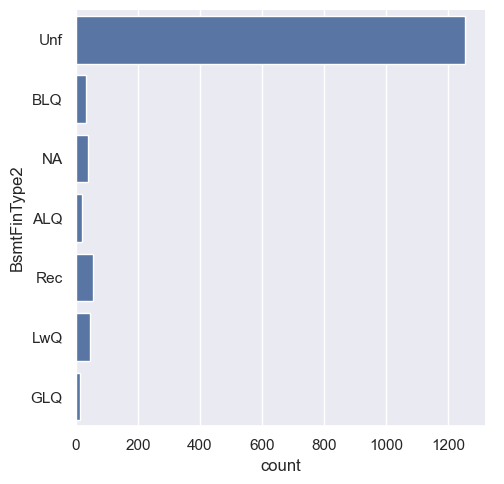

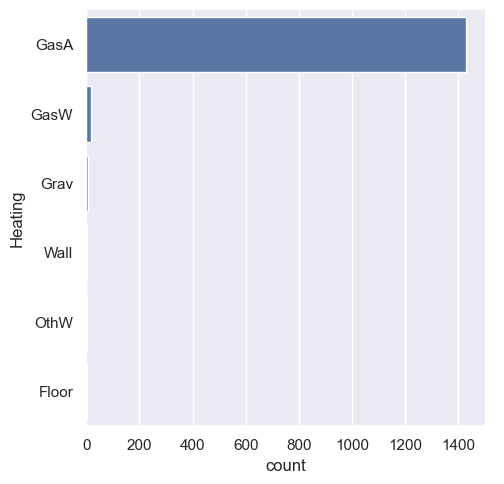

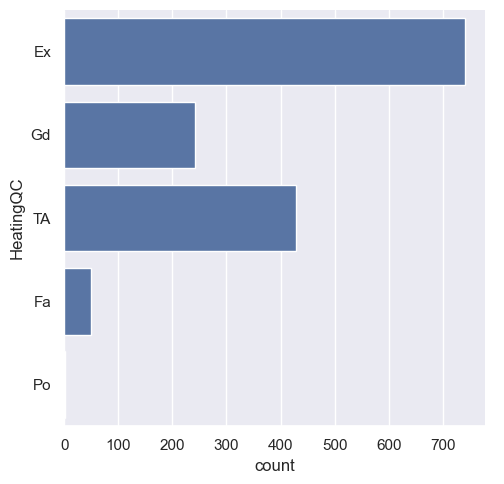

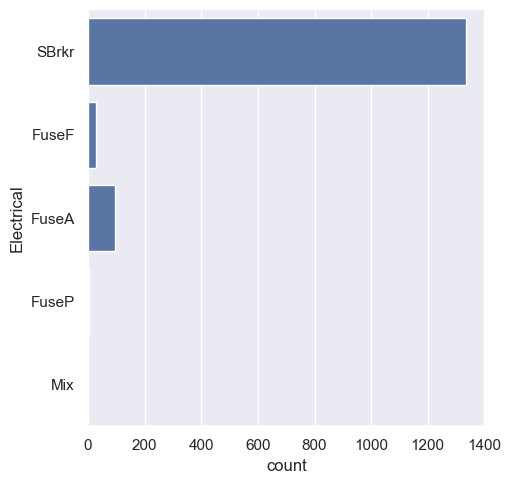

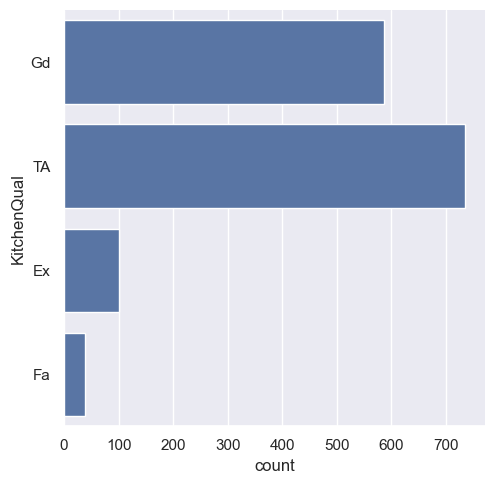

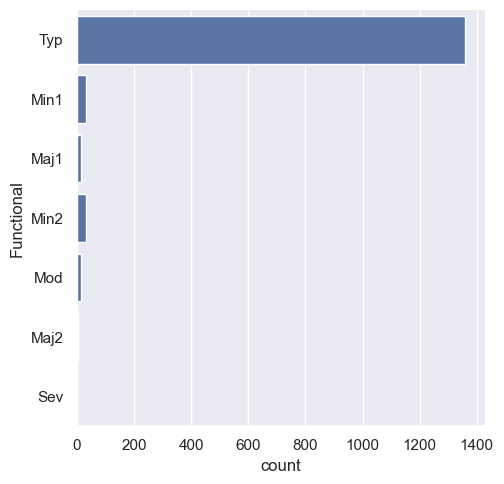

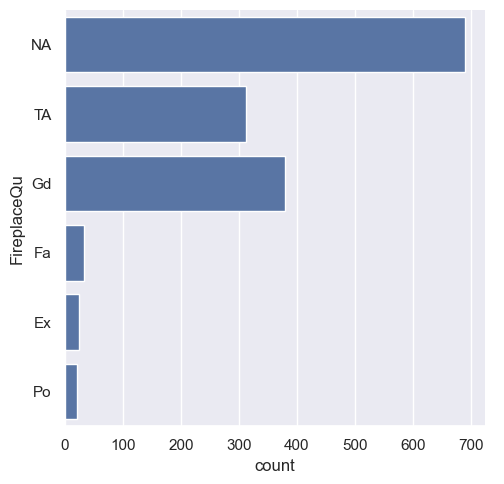

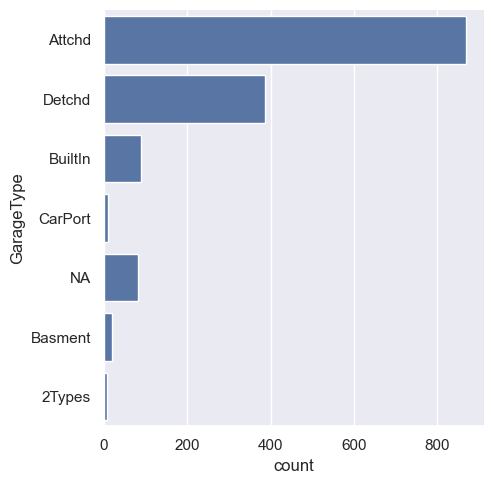

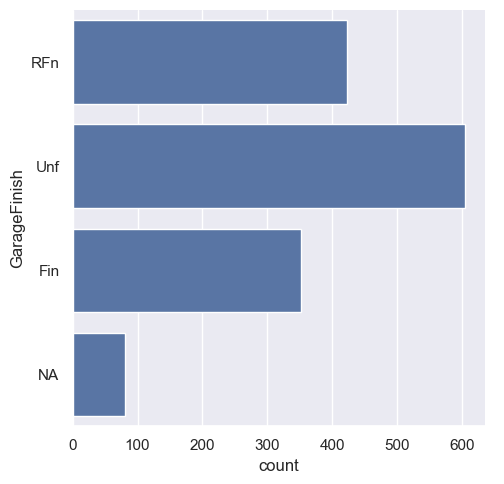

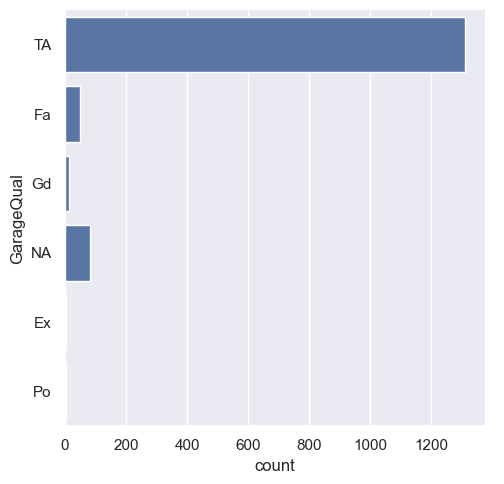

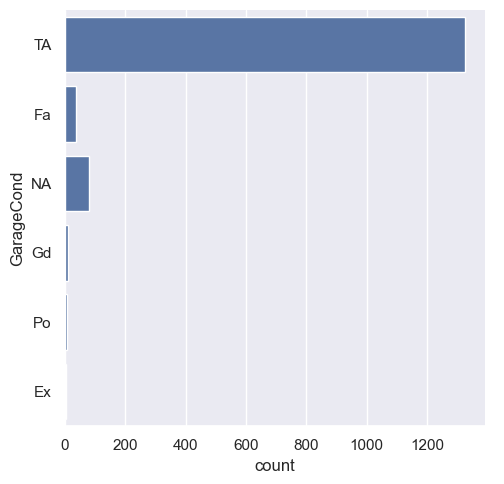

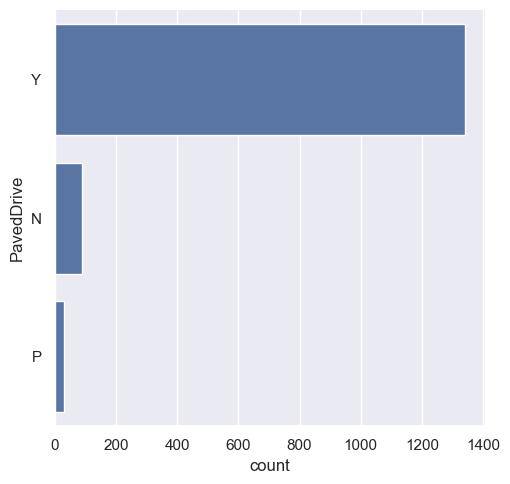

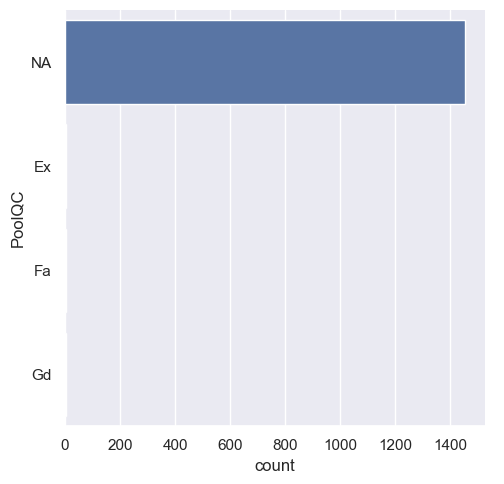

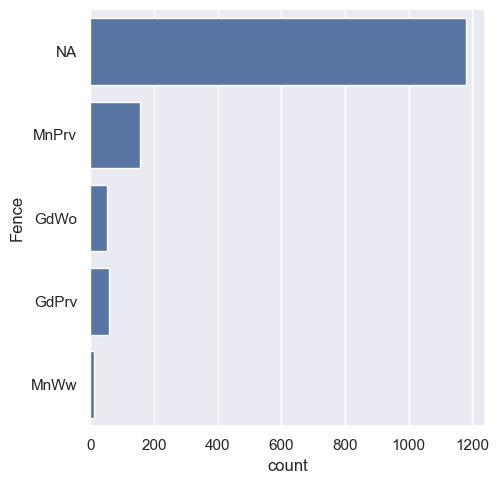

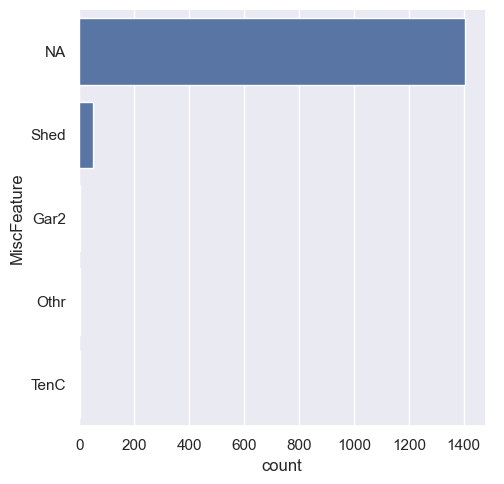

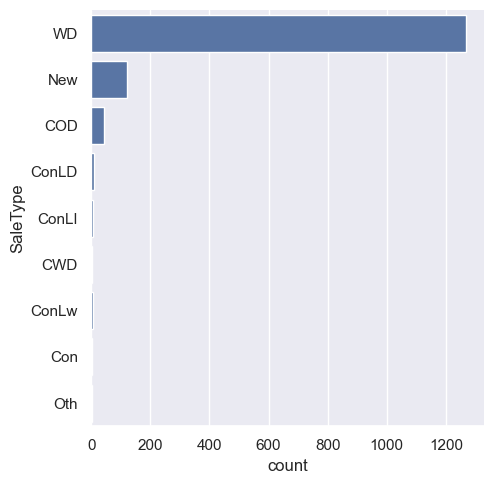

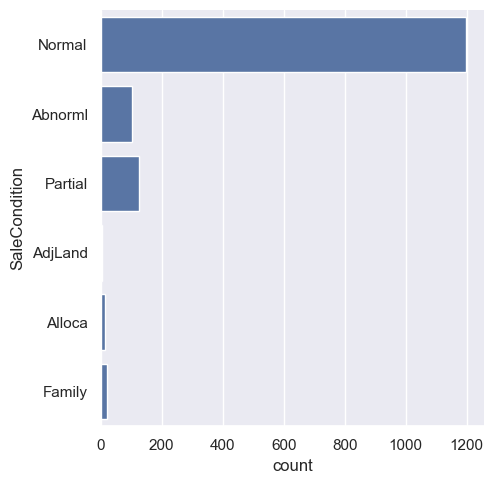

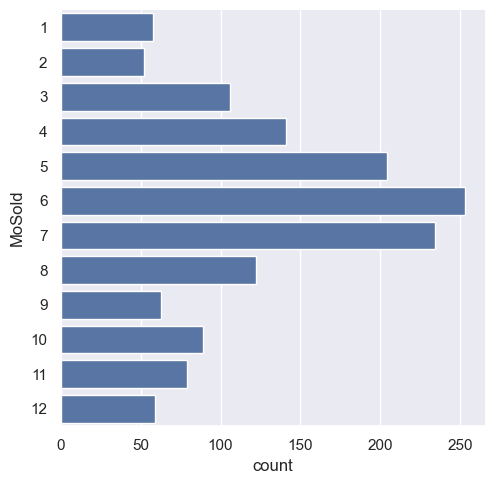

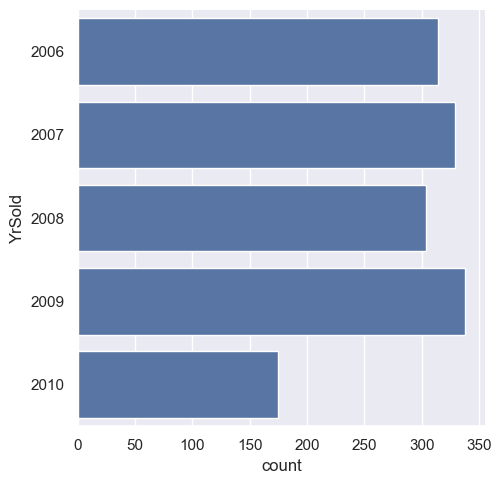

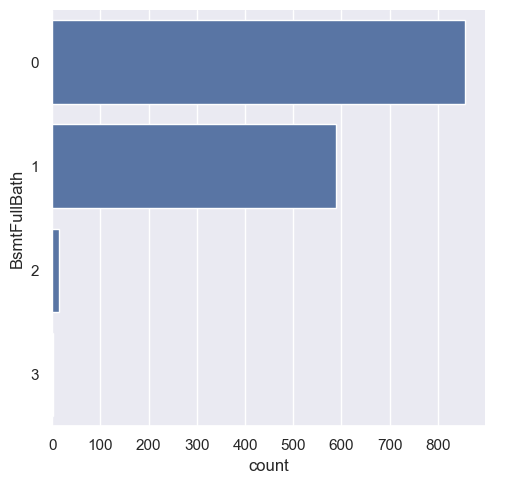

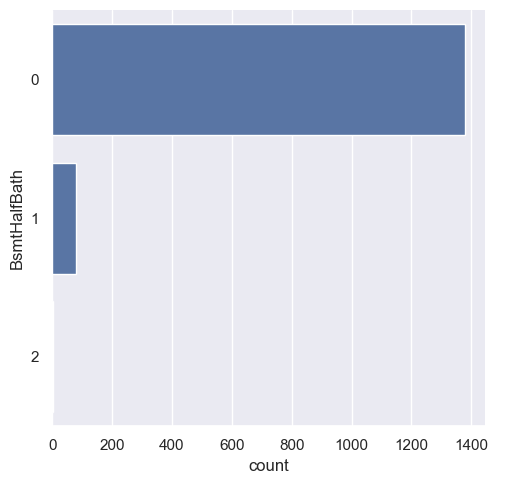

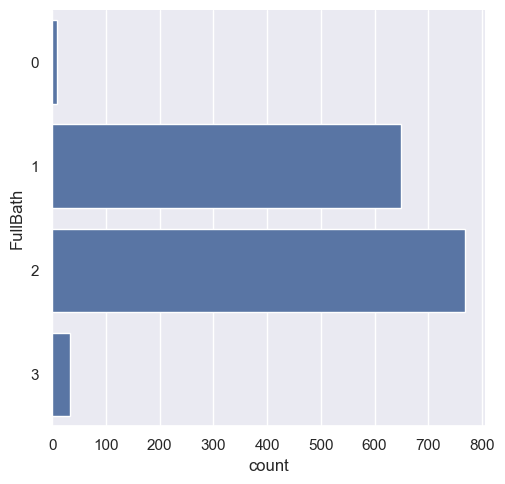

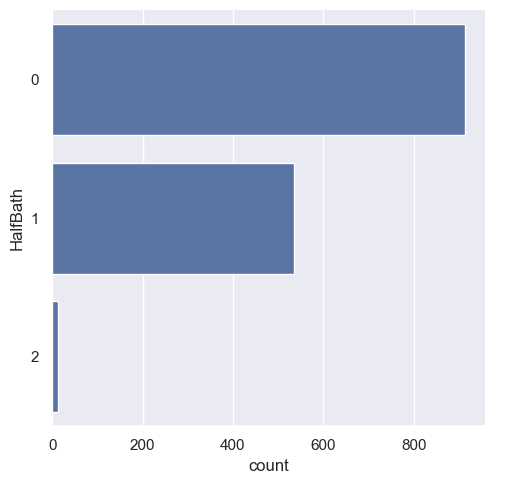

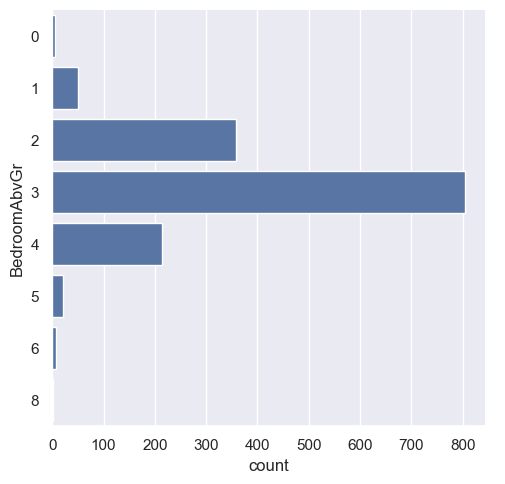

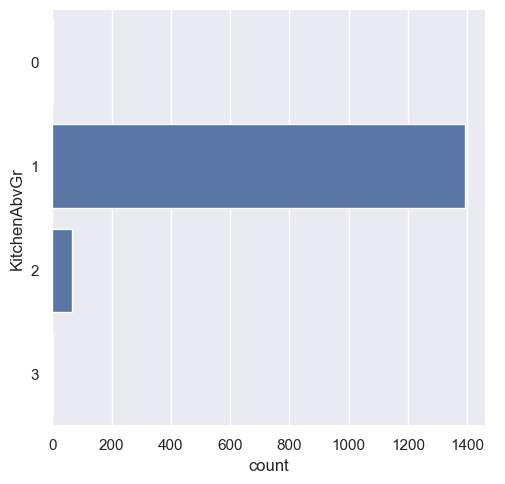

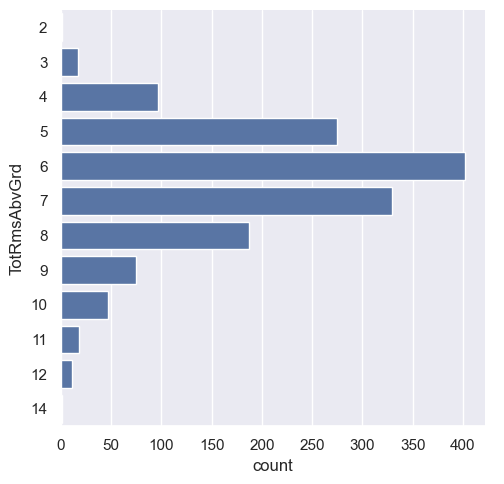

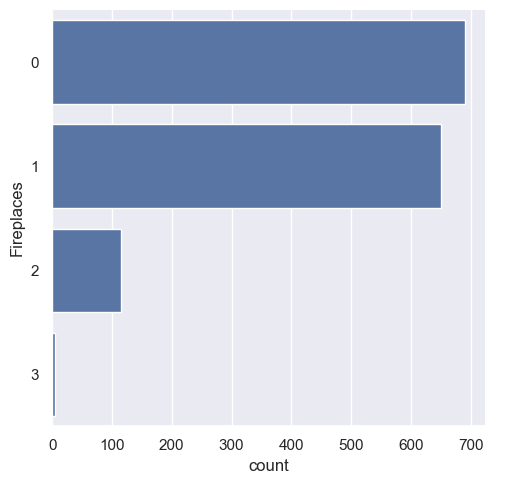

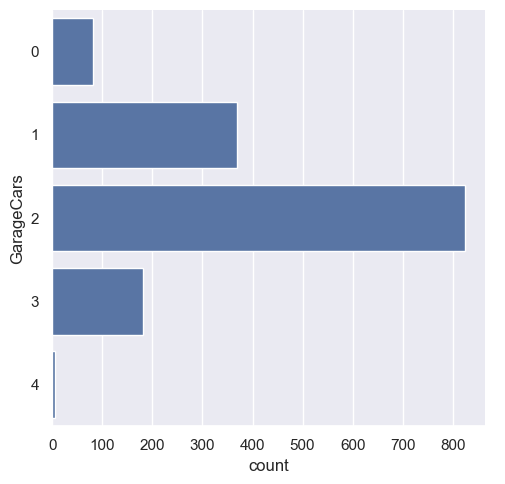

In [10]:
for column in high_cardinality:
    sb.catplot(y = column, data = cat_df, kind = "count")

In [11]:
# Summary Statistics for all Variables
cont_df.describe().round(2)

LotFrontage    LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
count      1460.00    1460.00    1460.00       1460.00     1460.00   
mean         70.20   10516.83    1971.27       1984.87      103.12   
std          22.43    9981.26      30.20         20.65      180.73   
min          21.00    1300.00    1872.00       1950.00        0.00   
25%          60.00    7553.50    1954.00       1967.00        0.00   
50%          70.00    9478.50    1973.00       1994.00        0.00   
75%          80.00   11601.50    2000.00       2004.00      164.25   
max         313.00  215245.00    2010.00       2010.00     1600.00   

       BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  \
count     1460.00     1460.00    1460.00      1460.00   1460.00  ...   
mean       443.64       46.55     567.24      1057.43   1162.63  ...   
std        456.10      161.32     441.87       438.71    386.59  ...   
min          0.00        0.00       0.00         0.00    334.00  ...   
25%          0.00        0.00     223.00       795.75    882.00  ...   
50%        383.50        0.00     477.50       991.50   1087.00  ...   
75%        712.25        0.00     808.00      1298.25   1391.25  ...   
max       5644.00     1474.00    2336.00      6110.00   4692.00  ...   

       GarageYrBlt  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count      1460.00     1460.00     1460.00      1460.00        1460.00   
mean       1868.74      472.98       94.24        46.66          21.95   
std         453.70      213.80      125.34        66.26          61.12   
min           0.00        0.00        0.00         0.00           0.00   
25%        1958.00      334.50        0.00         0.00           0.00   
50%        1977.00      480.00        0.00        25.00           0.00   
75%        2001.00      576.00      168.00        68.00           0.00   
max        2010.00     1418.00      857.00       547.00         552.00   

       3SsnPorch  ScreenPorch  PoolArea   MiscVal  SalePrice  
count    1460.00      1460.00   1460.00   1460.00     1460.0  
mean        3.41        15.06      2.76     43.49   180921.2  
std        29.32        55.76     40.18    496.12    79442.5  
min         0.00         0.00      0.00      0.00    34900.0  
25%         0.00         0.00      0.00      0.00   129975.0  
50%         0.00         0.00      0.00      0.00   163000.0  
75%         0.00         0.00      0.00      0.00   214000.0  
max       508.00       480.00    738.00  15500.00   755000.0  

[8 rows x 23 columns]

/var/folders/lf/q631jd0s5p5g91_m_mj76hgr0000gn/T/ipykernel_16418/517766666.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(cont_df[var], ax = axes[count,1])
/var/folders/lf/q631jd0s5p5g91_m_mj76hgr0000gn/T/ipykernel_16418/517766666.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(cont_df[va

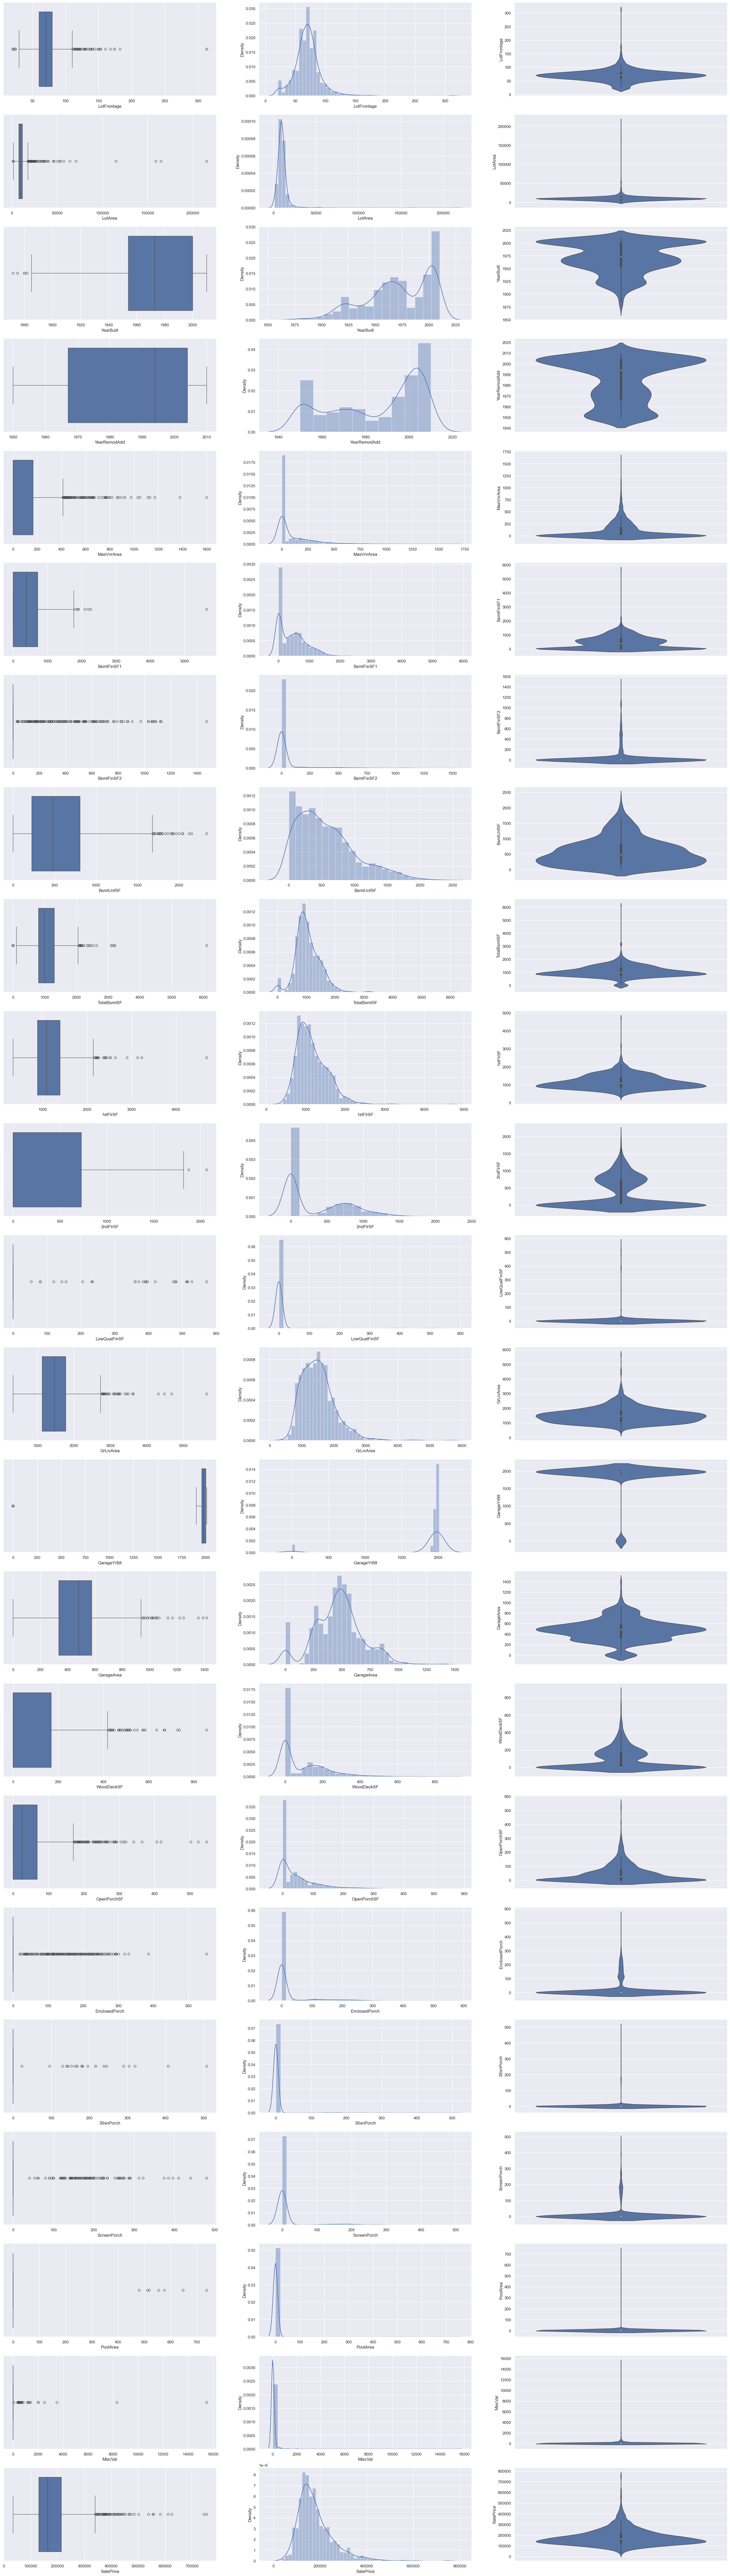

In [12]:
f, axes = plt.subplots(23, 3, figsize=(36, 128))

count = 0
for var in cont_df:
    sb.boxplot(cont_df[var], orient = "h", ax = axes[count,0])
    sb.distplot(cont_df[var], ax = axes[count,1])
    sb.violinplot(cont_df[var], ax = axes[count,2])
    count += 1

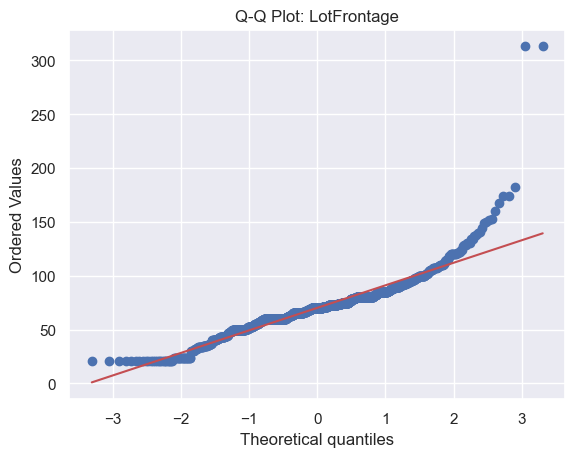

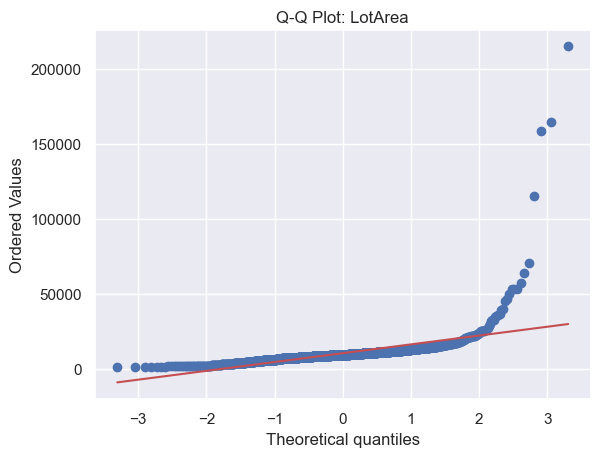

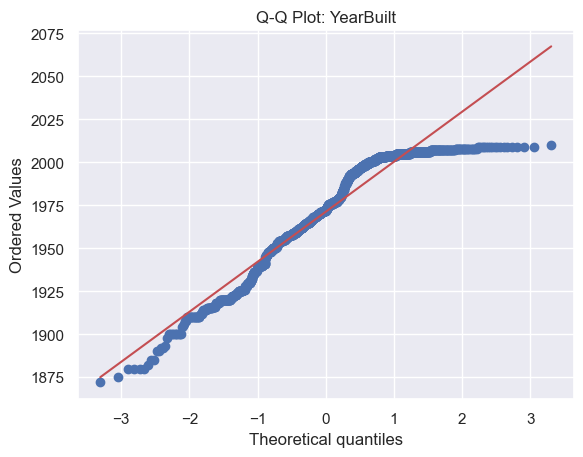

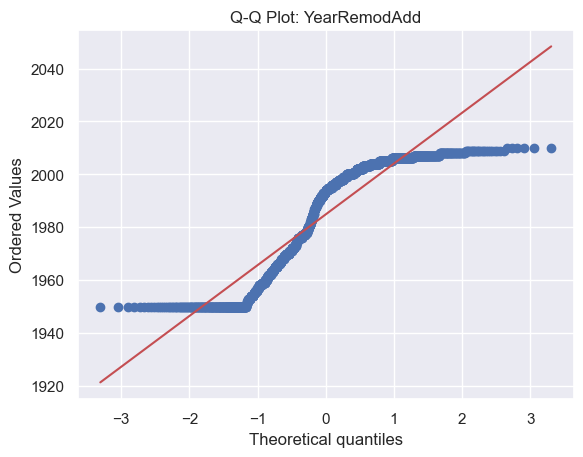

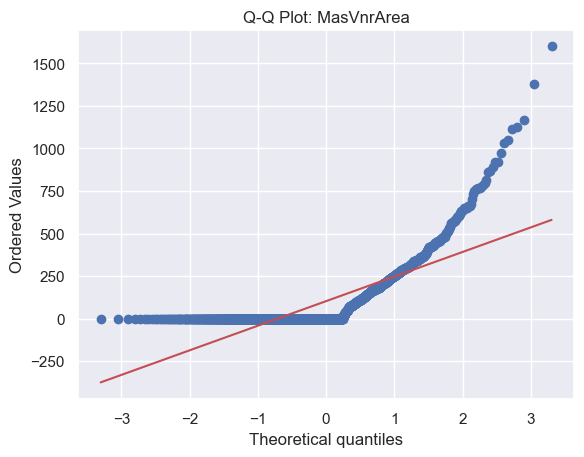

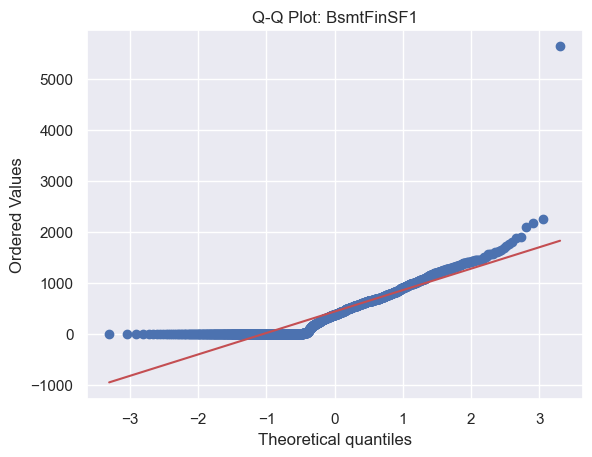

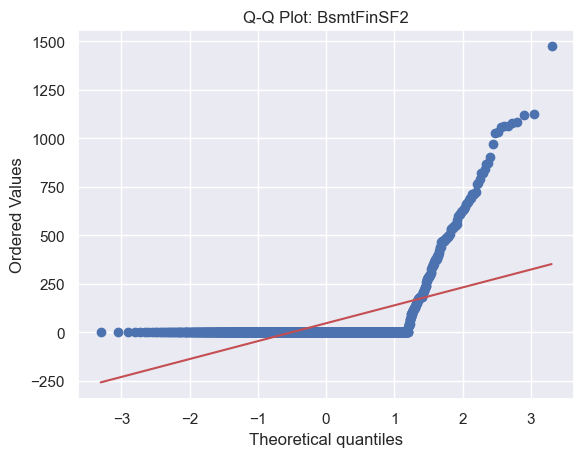

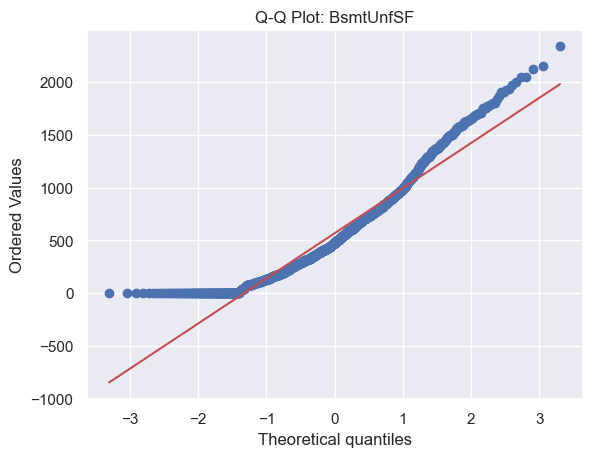

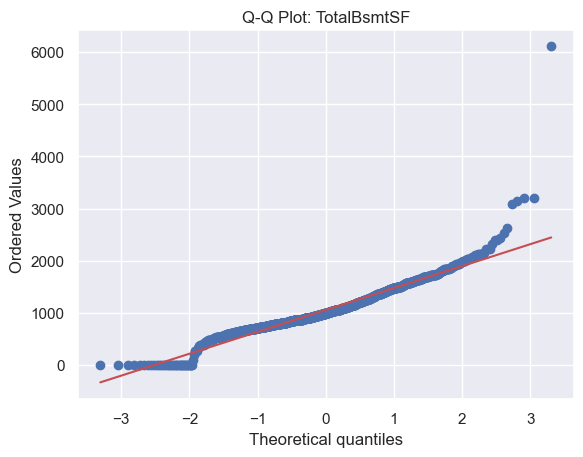

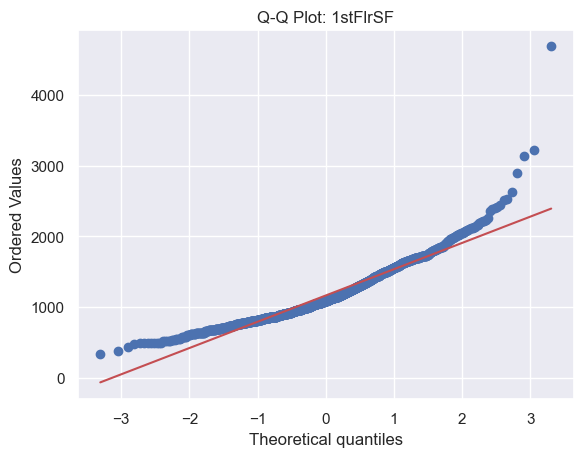

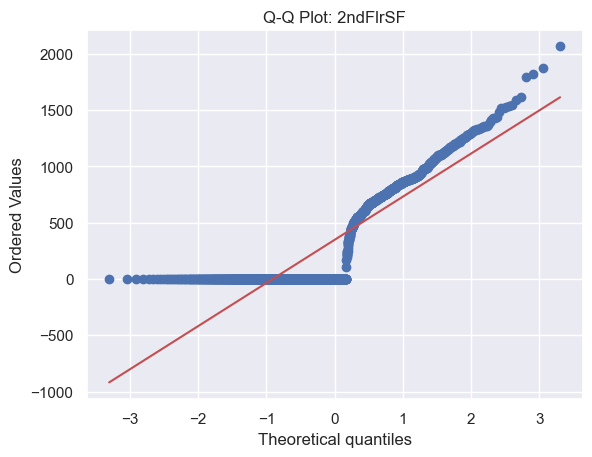

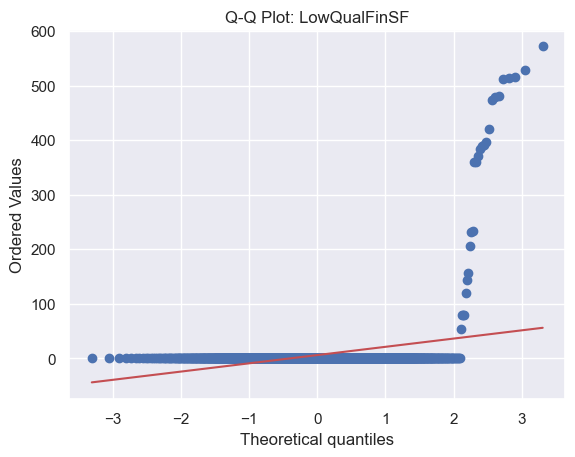

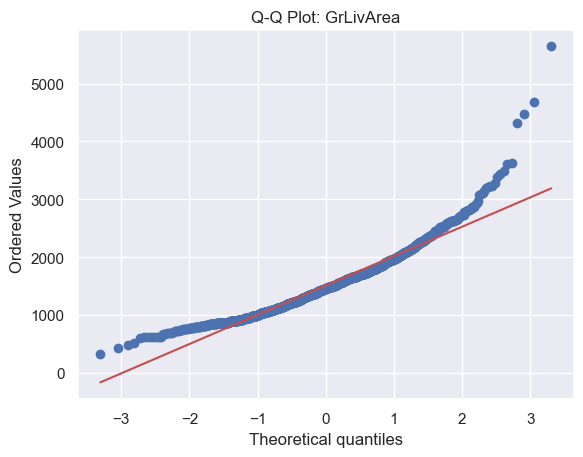

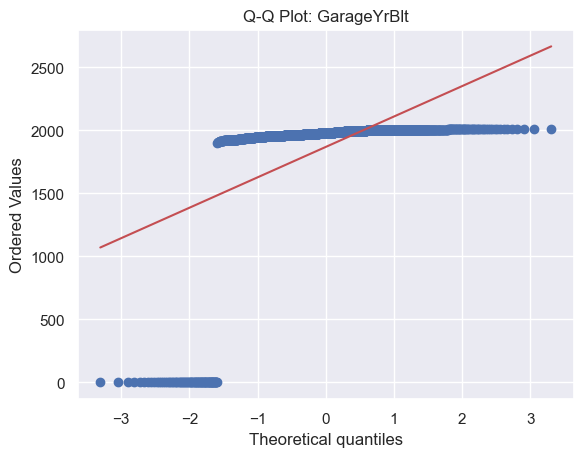

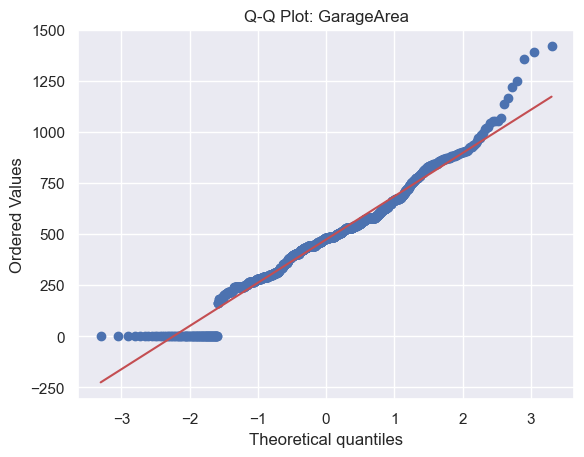

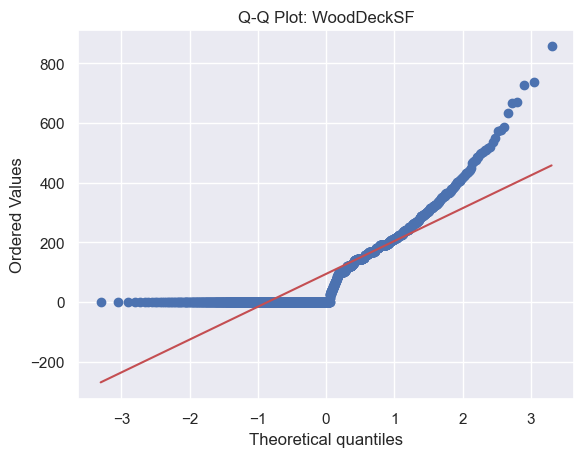

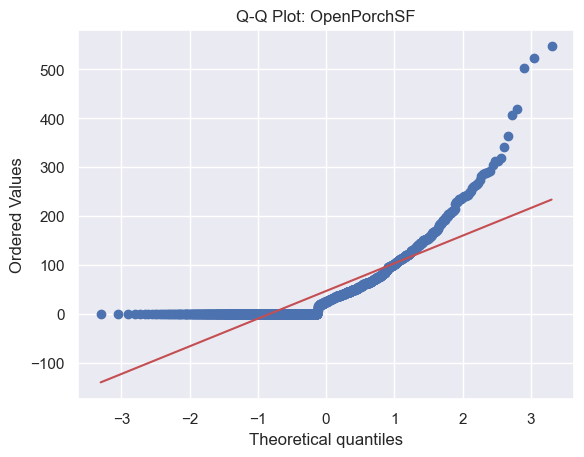

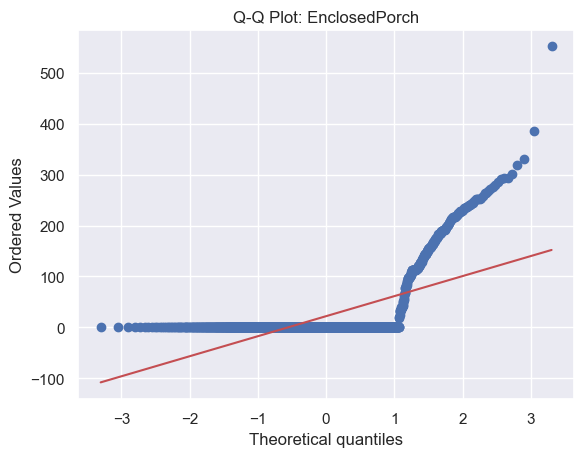

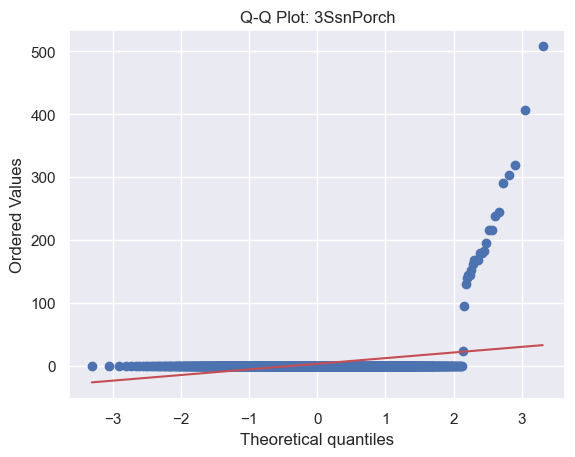

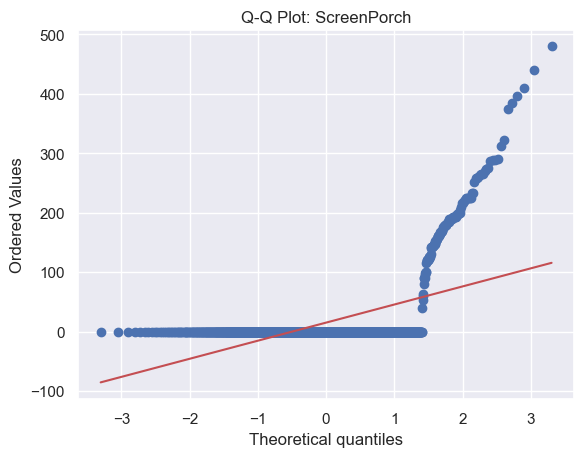

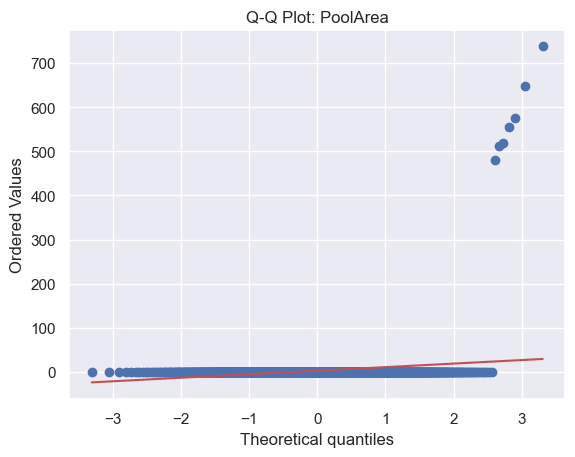

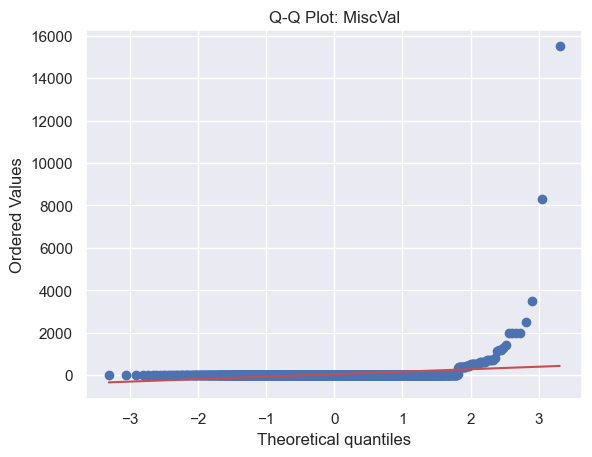

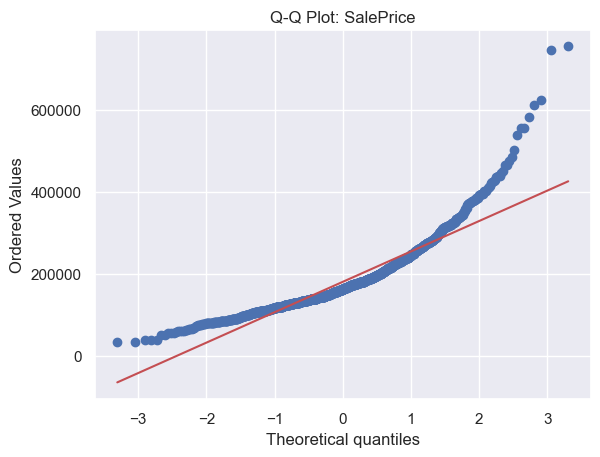

In [13]:
def qq_plot(column):
    stats.probplot(df[column].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot: {column}")
    plt.show()

for column in continuous_variables:
    qq_plot(column)

Transformation required : 
- LotArea
- MasVnrArea
- BsmtFinSF1
- BsmtFinSF2
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- GrLivArea
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- LowQualFinSF
- SalePrice

In [14]:
transform_columns = [
    'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'SalePrice'
]

# log transformation
df[transform_columns] = df[transform_columns].applymap(lambda x: np.log(x) if x > 0 else 0)
df.head()

/var/folders/lf/q631jd0s5p5g91_m_mj76hgr0000gn/T/ipykernel_16418/1506378539.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[transform_columns] = df[transform_columns].applymap(lambda x: np.log(x) if x > 0 else 0)


MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0          60       RL         65.0  9.041922   Pave    NA      Reg   
1          20       RL         80.0  9.169518   Pave    NA      Reg   
2          60       RL         68.0  9.328123   Pave    NA      IR1   
3          70       RL         60.0  9.164296   Pave    NA      IR1   
4          60       RL         84.0  9.565214   Pave    NA      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0     NA    NA          NA   
1         Lvl    AllPub       FR2  ...        0     NA    NA          NA   
2         Lvl    AllPub    Inside  ...        0     NA    NA          NA   
3         Lvl    AllPub    Corner  ...        0     NA    NA          NA   
4         Lvl    AllPub       FR2  ...        0     NA    NA          NA   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal  12.247694  
1       0      5    2007        WD         Normal  12.109011  
2       0      9    2008        WD         Normal  12.317167  
3       0      2    2006        WD        Abnorml  11.849398  
4       0     12    2008        WD         Normal  12.429216  

[5 rows x 80 columns]

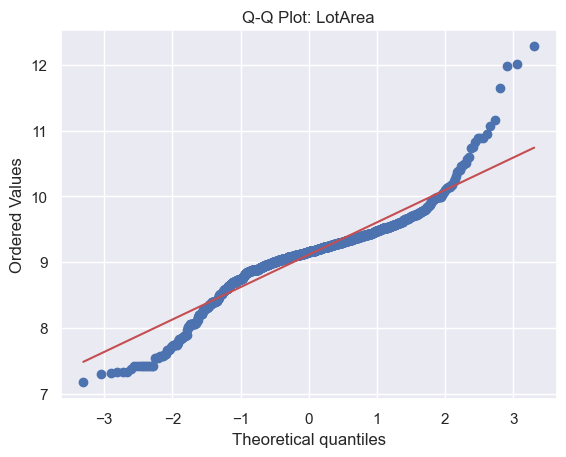

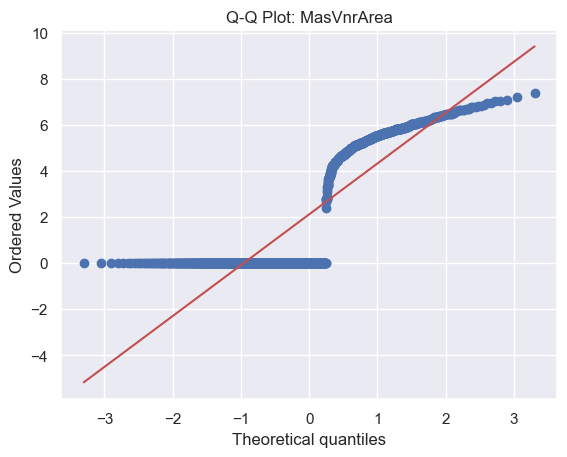

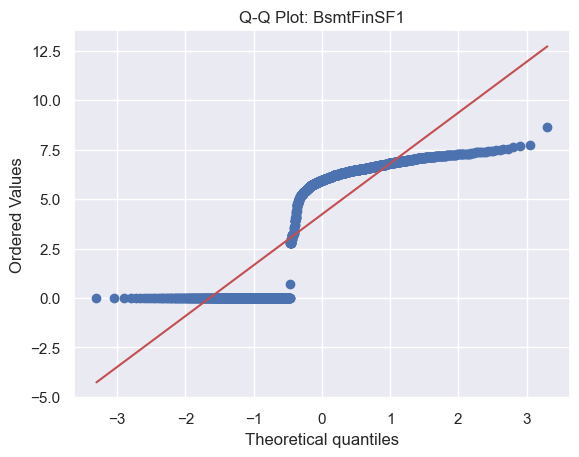

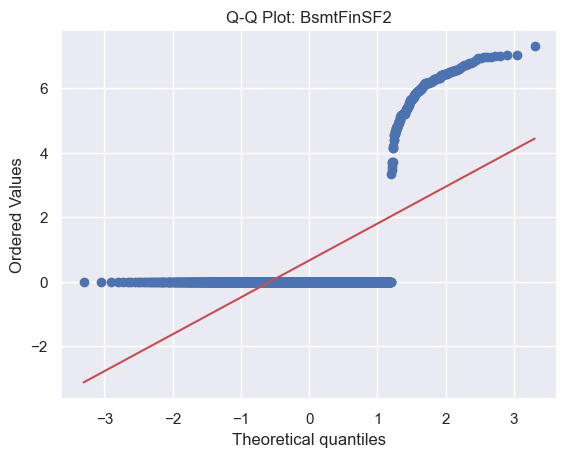

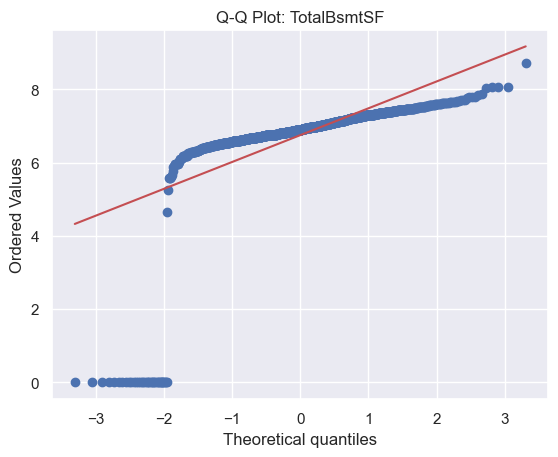

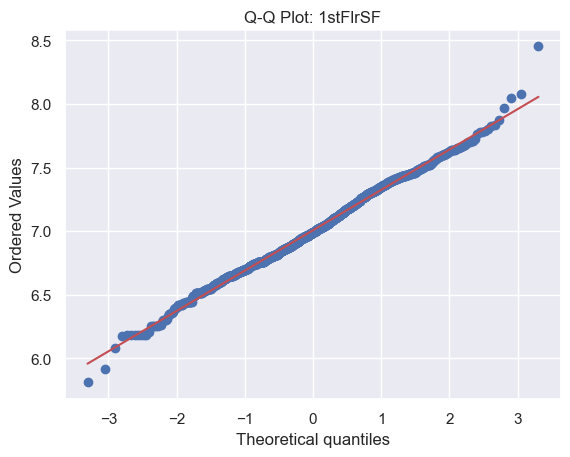

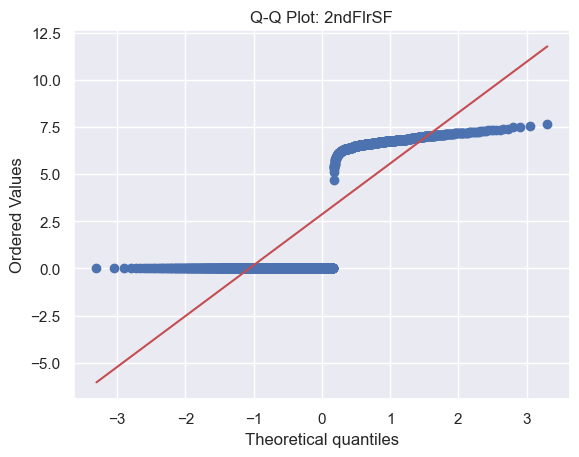

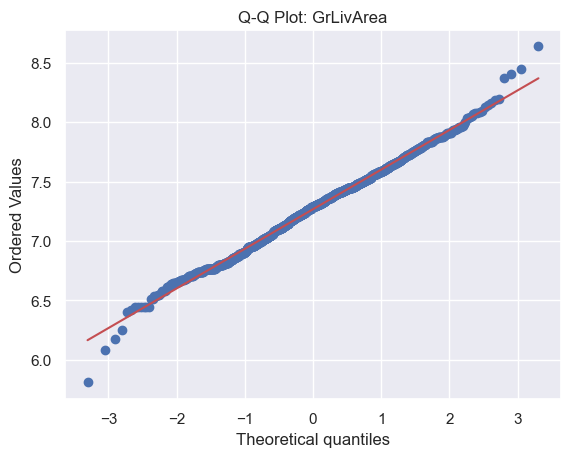

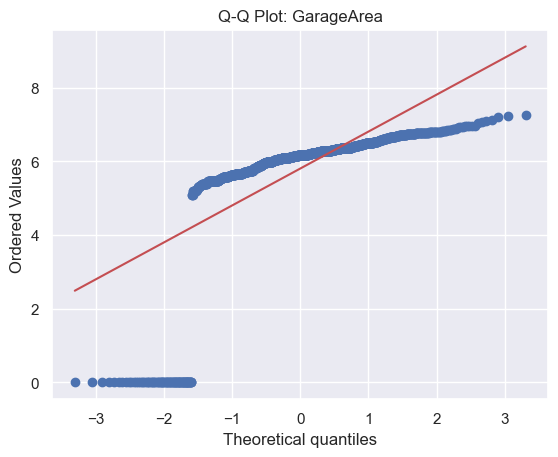

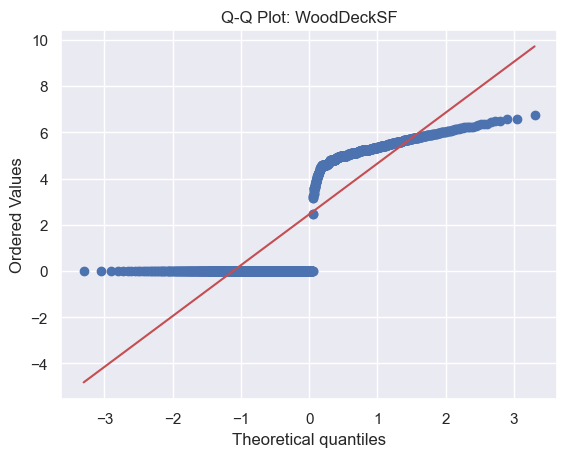

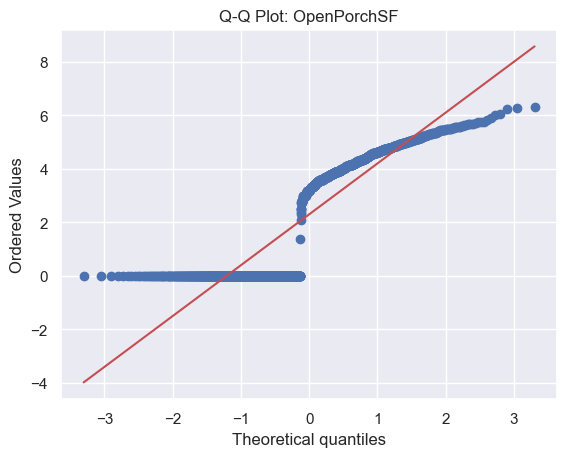

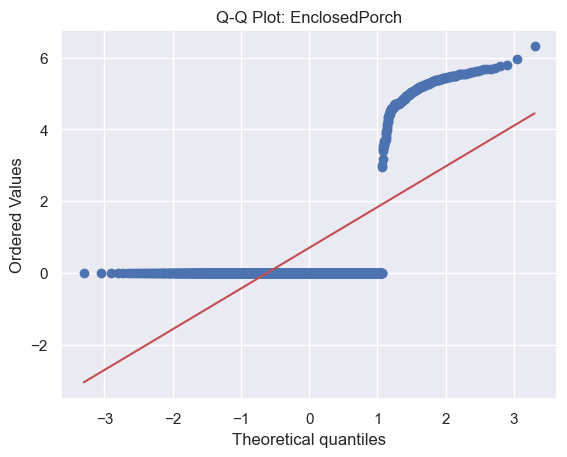

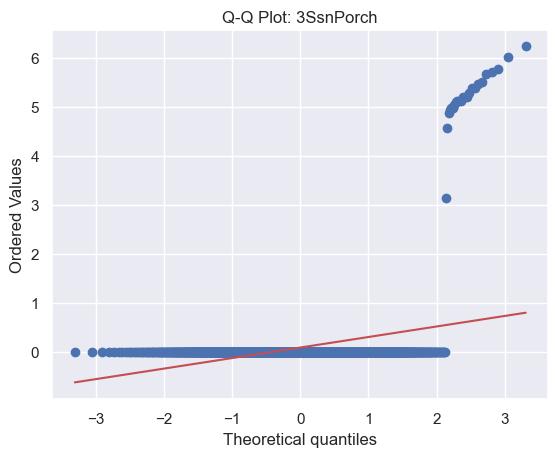

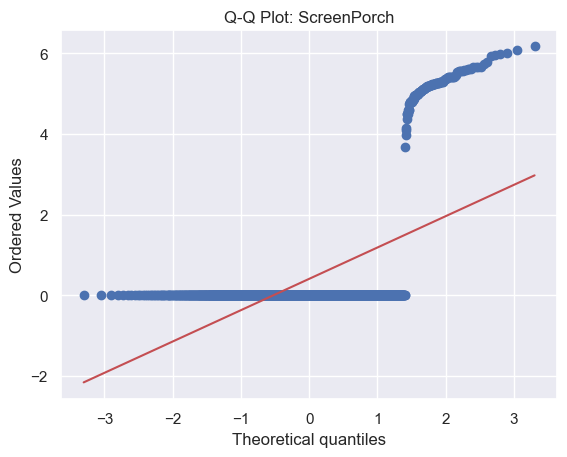

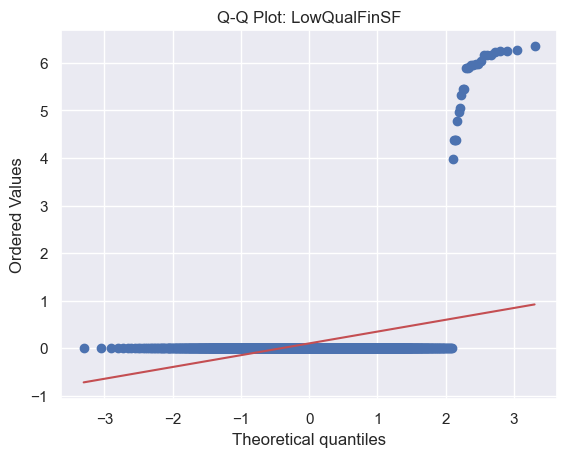

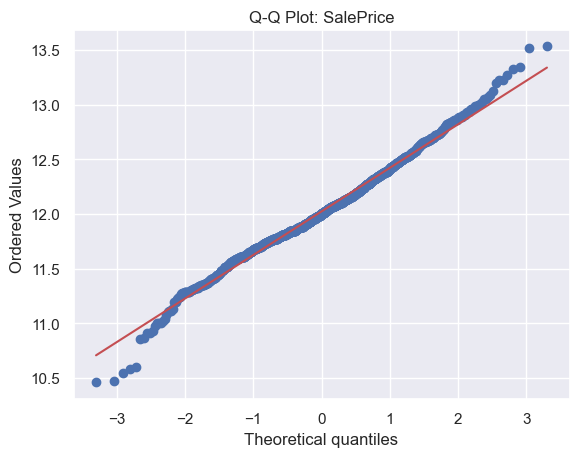

In [15]:
# check qq plot again

for column in transform_columns:
    qq_plot(column)

### Linear Regression

In [16]:
# one hot encoding for the categorical variables

df_v2 = pd.get_dummies(df, columns=categorical_variables, drop_first=True)

In [17]:
df_v2

LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
0            65.0  9.041922       2003          2003    5.278115    6.559615   
1            80.0  9.169518       1976          1976    0.000000    6.885510   
2            68.0  9.328123       2001          2002    5.087596    6.186209   
3            60.0  9.164296       1915          1970    0.000000    5.375278   
4            84.0  9.565214       2000          2000    5.857933    6.484635   
...           ...       ...        ...           ...         ...         ...   
1455         62.0  8.976768       1999          2000    0.000000    0.000000   
1456         85.0  9.486076       1978          1988    4.779123    6.672033   
1457         66.0  9.109636       1941          2006    0.000000    5.616771   
1458         68.0  9.181632       1950          1996    0.000000    3.891820   
1459         75.0  9.204020       1965          1965    0.000000    6.721426   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  TotRmsAbvGrd_11  \
0       0.000000        150     6.752270  6.752270  ...            False   
1       0.000000        284     7.140453  7.140453  ...            False   
2       0.000000        434     6.824374  6.824374  ...            False   
3       0.000000        540     6.628041  6.867974  ...            False   
4       0.000000        490     7.043160  7.043160  ...            False   
...          ...        ...          ...       ...  ...              ...   
1455    0.000000        953     6.859615  6.859615  ...            False   
1456    5.093750        589     7.340836  7.636752  ...            False   
1457    0.000000        877     7.049255  7.080026  ...            False   
1458    6.936343          0     6.982863  6.982863  ...            False   
1459    5.669881        136     7.135687  7.135687  ...            False   

      TotRmsAbvGrd_12  TotRmsAbvGrd_14  Fireplaces_1  Fireplaces_2  \
0               False            False         False         False   
1               False            False          True         False   
2               False            False          True         False   
3               False            False          True         False   
4               False            False          True         False   
...               ...              ...           ...           ...   
1455            False            False          True         False   
1456            False            False         False          True   
1457            False            False         False          True   
1458            False            False         False         False   
1459            False            False         False         False   

      Fireplaces_3  GarageCars_1  GarageCars_2  GarageCars_3  GarageCars_4  
0            False         False          True         False         False  
1            False         False          True         False         False  
2            False         False          True         False         False  
3            False         False         False          True         False  
4            False         False         False          True         False  
...            ...           ...           ...           ...           ...  
1455         False         False          True         False         False  
1456         False         False          True         False         False  
1457         False          True         False         False         False  
1458         False          True         False         False         False  
1459         False          True         False         False         False  

[1460 rows x 329 columns]

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = pd.DataFrame(df_v2["SalePrice"])
predictor_columns = [column for column in df_v2.columns if column != "SalePrice"]
X = pd.DataFrame(df_v2[predictor_columns])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Intercept of Regression 	: b =  [0.12010295]
Coefficients of Regression 	: a =  [[-6.06978258e-05  6.22076030e-02  2.14899556e-03  2.76166994e-04
   9.47983992e-05  8.27992886e-04 -5.54244664e-03 -6.31337229e-05
   1.14883019e-01 -6.77738490e-02 -6.86929344e-03 -7.52743983e-03
   5.26857839e-01  2.88772476e-04  5.35087636e-02  3.97031514e-03
   1.96730102e-03  4.40073090e-03  1.68423316e-02  1.09478909e-02
  -7.72208550e-04 -2.88295867e-05 -3.79493430e-02 -1.45600056e-01
  -1.34571977e-01 -9.55489929e-02 -8.17358078e-02 -4.41671218e-02
  -1.60913006e-01 -5.90420764e-02 -7.73103701e-02 -3.82230560e-02
  -5.53634635e-02 -1.92808620e-01 -8.08992939e-02 -4.56312435e-02
   4.28143957e-01  3.71584085e-01  3.73394369e-01  3.43570404e-01
   1.26837625e-01 -5.01229541e-03  3.16088357e-02  2.16119155e-02
   4.82772336e-02  3.27122269e-03  2.14202900e-02  2.89117346e-02
   1.50172210e-02 -2.53716538e-01  2.55217933e-02 -4.91635193e-02
  -8.01518569e-02 -1.02302191e-02  2.57616668e-02 -5.04135468e